# Reinforcement Learning: Train a Smartcab to Drive

> Udacity Machine Learning Engineer Nanodegree: _Project 4_
>
> Author: _Ke Zhang_
>
> Submission Date: _2017-05-02_ (Revision 2)

## Content

- [Getting Started](#Getting-Started)
- [Understand the World](#Understand-the-World)
- [Understand the Code](#Understand-the-Code)
- [Implement a Basic Driving Agent](#Implement-a-Basic-Driving-Agent)
- [Inform the Driving Agent](#Inform-the-Driving-Agent)
- [Implement a Q Learning Driving Agent](#Implement-a-Q-Learning-Driving-Agent)
- [Improve the Q Learning Driving Agent](#Improve-the-Q-Learning-Driving-Agent)
- [Future Rewards Question](#Optional:-Future-Rewards---Discount-Factor,-%27gamma%27)
- [References](#References)
- [Reproduction Environment](#Reproduction-Environment)

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [1]:
# Import the visualization code
import visuals as vs
import matplotlib.pyplot as plt
import seaborn as sns


# Pretty display for notebooks
%matplotlib inline
sns.set(style='white', palette='muted', color_codes=True)
sns.set_context('notebook', font_scale=1.2, rc={'lines.linewidth': 1.2})

#sklearn makes lots of deprecation warnings...
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

The Smartcab doesn't update its status and seems to **not move** at all during the simulation. It stays at the same position before a traffic light. In endless intervals it **gets positive and negative rewards**. It gets positive rewards to be idled at red light or with oncoming traffic and negative rewards when the light changed to green and there's no oncoming traffic.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

* **agent.py**: An agent that learns to drive in the Smartcab world.

| Flag | Description |
|------|-------------|
| num_dummies | Set the number of dummy agents in the environment which move randomly under legal traffic laws. (default: 100) Both **safty** and **reliability** are affected by the number of num_dummies. More dummies could hinder the learning agent by blocking the street or increase the possibility of accidents. |
| learning | Whether the agent is expected to learn using Q-table. (default: False, always default behaviour during the simulation) The Q-learning algorithm uses epsilon and alpha as random exploration and learning factors. |
| enforce_deadline | Whether the agent is enforced to meet deadline and to stop the agent when it ran out of time. (default: False, endless loop) |
* **environment.py**: Environment within which all agents operate.
    * The **act** function is called when an agent performs an action. It considers an action and performs the action if it is legal. It also determines thereward for the agent based on traffic laws. 
* **simulator.py**: Simulates agents in a dynamic smartcab environment and uses PyGame to display GUI, if available.
    * The **render_text()** function is the non-GUI renderer of the simulation. It prints the simulated trial data into the terminal prompt.
    * The **render()** function is the GUI renderer of the simulation. It uses PyGame to display GUI and uses supplementary trial data from the *render_test* function.
* **planner.py**: Complex route planner that is meant for a perpendicular grid network.
    * The **next_waypoint()** function will consider the **East or West** directions first and then the *North or South* directions. It creates the next waypoint based on current heading, location, intended destination and L1 distince from destination.


-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


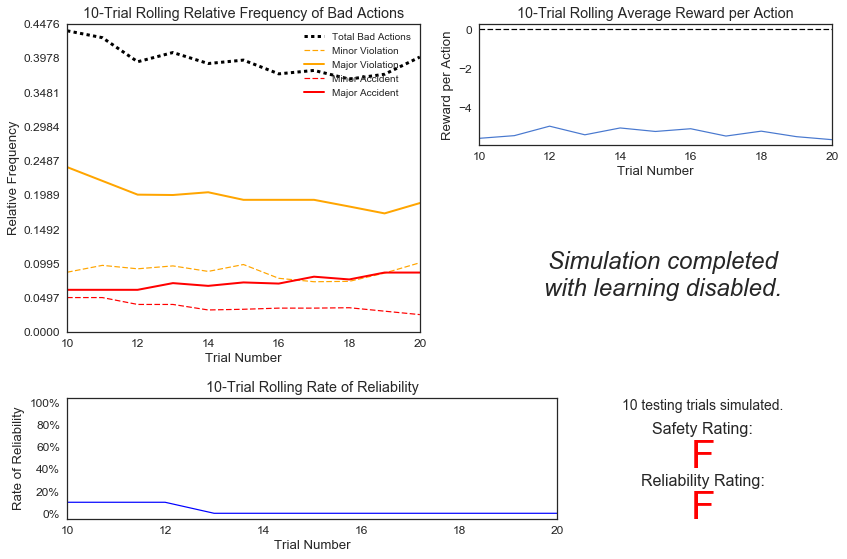

In [2]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

Panel: "**10-Trial rolling Relative Frequency of Bad Actions**"
* The driving agent is making bad decisions at about 40% of the time. Half of the bad decisions results in major violations. The other half causes minor violations and minor or major accidents.

Panel: "**10-Trial Rolling Average Reward per Action**"
* In rolling average the agent is receiving negative rewards for his bad decisions.
* As the number of trials increases, the outcome of results stays at the same level and remains negative.

Panel: "**10-Trial Rolling Rate of Reliability**"
* The reliability rate falls from 30% at the beginning to below 10%. The rolling rate of reliability indicates that without learning the agent is continously making mistakes and thus the reliability falls and stays at a very low level.

Panel: "**10 testing trials simulated**"
* After 10 testing trials the simulation without learning results in a **F** score in both *Safety Rating* and *Reliability Rating*.
    * Safety Rate = F:  Agent causes at least one major accident, such as driving through a red light with cross-traffic
    * Reliability Rate = F: Agent fails to reach the destination on time for at least 60% of trips.
* According to the ratings, this Smartcab version is not safe or reliable for its passengers.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**

Features available to the agent **ordered** by the relevance for learning both *Safety* and *Efficiency*:

| rank | feature | selected? | reasoning |
|------|---------|-----------|-----------|
| 1    | inputs/oncoming | yes | *Safty-first* rule. These features tells the agent which directions it should avoid. They are the most relevant to the *Safty* rating which is highly sensitive to even the smallest accidents. |
| 1    | inputs/left     | yes | (see above) |
| 2    | inputs/light    | yes | Light signals allow the agent to avoid traffic violations which could decrease the *Safety* grades. |
| 2    | waypoint        | yes | It contains the direction information leading to the destination and is relevant for the *Reliability* rating. |
| 3    | inputs/right    | no | <ul><li>To be further analyzed: By looking at the simplified simulation environment and the algorithm of the dummy agents. It seems that in case the light is green that the Smartcab always has the right-of-ways. And in case the light is red, it has to stop anyways. However, in reality the Smartcab should follow the *Safty-first* rule of course. There's always a given possibility that other human drivers don't follow the traffic laws and make inevitable failures.</li><li>Furthermore, the Smartcab doesn't need the *right* information to find the correct way to the destination.</li></ul> |
| 4    | deadline        | no  | <ul><li>The simulation environment is too simple for advanced routing algorithms. There's no highways or main roads with less traffic lights or intersections. The streets are all of the same lengths and the optimal route is always to drive towards the direction of the destination. Thus in our case the *deadline* information is useless. There's neither strategies like avoid traffic lights or road intersections to gain rewards of safely driving.</li><li>And the last thought to use *deadline* to decide whether to commit traffic violations or not, is not an option because as said earlier te *Safty* rating which is highly sensitive to even the smallest accidents.</li></ul> |


### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

States of the selected features by given the information about the environment and its simulation details in *environment.py*:

| feature | states | # states |
|---------|--------|----------|
| inputs/oncoming | *none, forward, left, right* | **4** |
| inputs/left | *none, forward, left, right* | **4** |
| inputs/light | *green, red* | **2** | 
| waypoint | *forward, left, right* | **3** |

* The total number of possible states is: **96**.
* The driving agent has 4 possible actions (*none, forward, left and right*) for each possible state which makes a total number of combinations of **384**.
* The total number of combinations is not very large and we assume that the driving agent can learn a policy for each possible state within a reasonable number of training trials.


### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

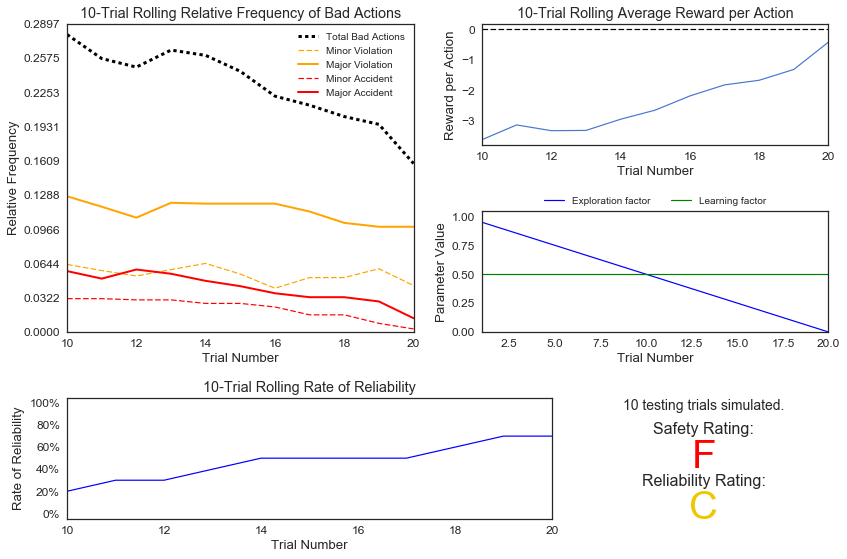

In [3]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

Panel: "**10-Trial rolling Relative Frequency of Bad Actions**"
* With the basic learning algorithm the driving agent begins to make the correct decisions progressively. As the number of trials increases, the rolling relative frequency of bad actions falls from over 30% at the beginning to 15% after 20 trials.
* Compared to the basic version the rates of traffic violations and accidents dropped more than a half.

Panel: "**Exploration and Learning Parameters**"
* It took **20 trials** before testing.
* The number makes sense. The Q-learning agent begins testing when the exploration factor ϵ value falls below the *tolerance* level (default: 0.05). Using the linear decaying function with a step size of **.05**, the ϵ value falls from 1.0 to 0.05 in **20 trials**.

Panel: "**10-Trial Rolling Average Reward per Action**"
* The rolling average reward has increased over time. Even though it's still negative after 20 trials, it's actually very close to the breakthrough point.

Panel: "**10-Trial Rolling Rate of Reliability**"
* The reliability rate increases from 20% at the beginning to over 70% and resulted in a *C* rating in *Reliability*.

Panel: "**10 testing trials simulated**"
* As mentioned previouslyu, the **Reliability** has improved from *F* to **C** while the **Safety** remained at **F** rating.
* As a final word on the initial Q-learning simulation: This version of Smartcab is still not reliable or safe for its passengers.


-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

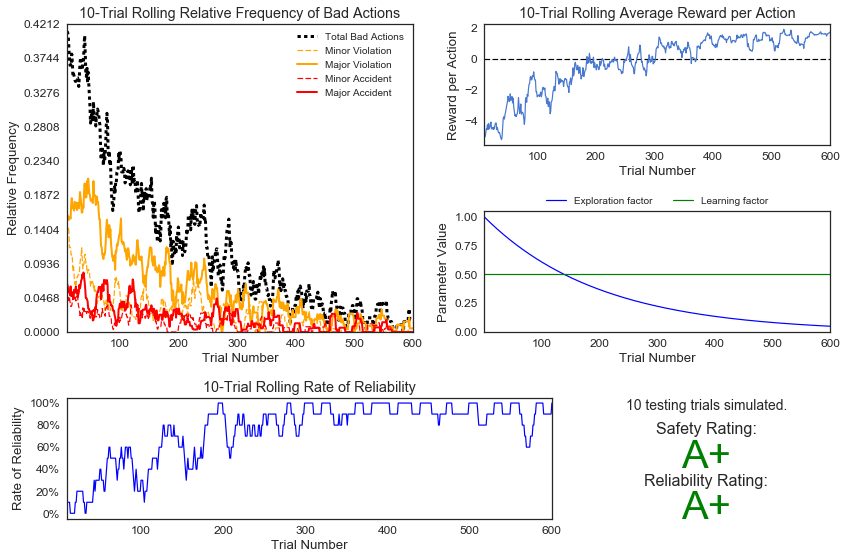

In [4]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

- *What decaying function was used for epsilon (the exploration factor)?*
> The final optimized decaying function used for epsilon: 
>
> $$\epsilon = e^{-.005t}$$
> 
- *Approximately how many training trials were needed for your agent before begining testing?*
> The Q-learning agent needed approx. 600 training trials before beginning testing as showed in the *Exploration and Learning Parameters* panel. This number can bederived from the inequality:
> $$ \epsilon ≥ tolerance \rightarrow e^{-0.005t} ≥ 0.05 $$
> $$ \rightarrow x ≥ \frac{ln(0.05)}{-0.005} \rightarrow x ≥ 599.15 $$
>
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
> Eventually we used the default values because they performed the best among the tried combinations. 
> * epsilon-tolerance: 0.05
>     * After some experimenting the default ε works well with the optimized decaying function. It implies enough amount of training trials and gives the agent enough ratio to acting on learned behavior.
> * alpha (learning rate): 0.5
>     * In the learn function the default alpha seems to be the value maximizing the Q values of each actions. Tuning the alpha value in both directions results in worse results. 
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
> Both *Safty* and *Reliability* ratings improved from *F* to *A+*. After the 600 training trials the violation and accident rates become vanishingly small. And the rolling rate of reliability becomes more and more stable at a rate close to 100%. The rolling average reward per action increased also to almost 2 reward per action.
> 
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
> Yes. The optimized Q-Learner is far more superior than the default version and produces guarantted safe and reliable results in the simulated environment.
>
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*
> Yes. With a double A+ ratings for *Safty* and *Reliability* our passengers would be certainly satisfied.
>

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** 

A list of the U.S. right-of-way traffic laws can be found on this [page](https://www.justlanded.com/english/United-States/Articles/Travel-Leisure/General-Road-Rules).

**State**: {oncoming: right, left: None, light: green, waypoint: forward}

| trained action  | rewards (Q) | expected? | explanation |
|-----------------|---|-----------|-----------|
| None    | -5.21   | yes | negative reward for idle at a green light with no oncoming traffic |
| **forward** | **1.89**    | **yes** | **positive reward for following the waypoint** |
| left    | -18.30  | yes | negative reward for drive through traffic and cause minor accidents |
| right   | 0.68    | yes | minor positive reward for valid but incorrect action |
* **Optimal Policy**: The optimal policy with the highest Q value was to drive forward heading for the direction of the waypoint given a green light with a right-turning oncoming car. 
* **Explanation**: The optimal policy is consistent with the expected policy. Following the rules, when the waypoint is to go forward and we have green, we can just drive forward.

**State**: {oncoming: None, left: right, light: red, waypoint: right}

| trained action  | rewards (Q) | expected? | explanation |
|-----------------|---|-----------|-----------|
| None    | 1.4   | yes | positive reward for properly idled at a red light |
| forward | -9.81 | yes | negative reward for running a red light and cause minor accidents |
| left    | -8.75 | yes |  negative reward for running a red light and cause minor accidents |
| **right**   | **2.43**  | **yes** | **positive reward for following the waypoint** |
* **Optimal Policy**: Running a red light and with left side blocked by a right-turning car, the optimal policy is the turn right heading for the direction of the waypoint.
* **Explanation**: There're many controversies with right-turns on red in reality. It is permitted in many regions of [North America](https://en.wikipedia.org/wiki/Turn_on_red). As in our case, turning right on red is not punished by negative reward. And our agent is given positive reward by following the waypoint. When we picture the traffic situation, actually it's considerablely safe to drive this way. The agent will cause any accidents in any case.
    * But in other regions and countries running a red light is considered as a major traffic violation. We can imagine when the autonomous driving gets more popular, the situation will change. Because it's more efficient to allow the right turn on red. The Smartcab has only to check if there are oncoming cars turning left or any pedestrians on the road. When there's no oncoming car and the car on the left is turning right, the Smartcab can be absolutely sure that it's safe for him to turn right. 


-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

The use of future rewards (reward for reaching the goal) is invalidated by the following two characteristics:
* Smartcab related:
    * It's the case that the Q-learning car knows the dealine (remaining time), but the information about the remaining distance is missing which is necessary to to formulate a reward function for future rewards.
* Environment related:
    * Furthermore a future reward can only be applied if there're alternatives. To calculate alternative routes we need at least the coordinates of the destination and a map of the surroundings to allow the back propagation of rewards from the destination towards the agent and let the agent to learn the route.
    * Another uncertainty are the current traffic state and light conditions. By calculus there's an optimal route of all possible routes from the current point to the destination when all attributes are constant. However, after each single move these attributes change randomly, thus it's impossible for the agent to capture the optimal future rewards.
    * It was also impossible to compare on a trial-by-trial basis because the destination was randomly selected in each trial.

## References:

* [Udacity - Reinforcement Learning](https://www.udacity.com/courses/reinforcement-learning--ud600)
* [Wikipedia - Turn on red](https://en.wikipedia.org/wiki/Turn_on_red)

## Reproduction Environment

In [5]:
import IPython
print IPython.sys_info()

{'commit_hash': u'5c9c918',
 'commit_source': 'installation',
 'default_encoding': 'cp936',
 'ipython_path': 'C:\\dev\\anaconda\\lib\\site-packages\\IPython',
 'ipython_version': '5.1.0',
 'os_name': 'nt',
 'platform': 'Windows-7-6.1.7601-SP1',
 'sys_executable': 'C:\\dev\\anaconda\\python.exe',
 'sys_platform': 'win32',
 'sys_version': '2.7.13 |Anaconda custom (32-bit)| (default, Dec 19 2016, 13:36:02) [MSC v.1500 32 bit (Intel)]'}


In [6]:
!pip freeze

alabaster==0.7.9
anaconda-client==1.6.0
anaconda-navigator==1.4.3
argcomplete==1.0.0
astroid==1.4.9
astropy==1.3
Babel==2.3.4
backports-abc==0.5
backports.shutil-get-terminal-size==1.0.0
backports.ssl-match-hostname==3.4.0.2
beautifulsoup4==4.5.3
bitarray==0.8.1
blaze==0.10.1
bokeh==0.12.4
boto==2.45.0
Bottleneck==1.2.0
cdecimal==2.3
cffi==1.9.1
chardet==2.3.0
chest==0.2.3
click==6.7
cloudpickle==0.2.2
clyent==1.2.2
colorama==0.3.7
comtypes==1.1.2
conda==4.3.16
configobj==5.0.6
configparser==3.5.0
contextlib2==0.5.4
cookies==2.2.1
cryptography==1.7.1
cycler==0.10.0
Cython==0.25.2
cytoolz==0.8.2
dask==0.13.0
datashape==0.5.4
decorator==4.0.11
dill==0.2.5
docutils==0.13.1
enum34==1.1.6
et-xmlfile==1.0.1
fastcache==1.0.2
Flask==0.12
Flask-Cors==3.0.2
funcsigs==1.0.2
functools32==3.2.3.post2
futures==3.0.5
gevent==1.2.1
glueviz==0.9.1
greenlet==0.4.11
grin==1.2.1
h5py==2.6.0
HeapDict==1.0.0
idna==2.2
imagesize==0.7.1
ipaddress==1.0.18
ipykernel==4.5.2
ipython==5.1.0
ipython-genutils==0.1.0